# Lid Driven Cavity : DeepOnet Model

## Download Dataset

In [14]:
from huggingface_hub import login, snapshot_download
from google.colab import userdata

# Login to Hugging Face using the token
print("Logging into Hugging Face...")
hf_token = userdata.get("hf_token")
login(token=hf_token)

# Specify repository and folder details
repo_id = "BGLab/FlowBench"  # Repository ID on Hugging Face
dataset_path = "LDC_NS_2D/128x128"  # Folder path within the repository
output_dir = "/content/drive/MyDrive/ldc_128_naiver_stokes"  # Local directory to save the folder

# Download the entire repository or specific folder
print(f"Downloading folder '{dataset_path}' from repository '{repo_id}'...")
snapshot_download(repo_id, repo_type="dataset", local_dir=output_dir, allow_patterns=[f"{dataset_path}/*"])

print(f"Folder downloaded successfully to {output_dir}!")

Logging into Hugging Face...


Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

LDC_NS_2D/128x128/harmonics_lid_driven_c(…):   0%|          | 0.00/336M [00:00<?, ?B/s]

Folder downloaded successfully to /content/drive/MyDrive/ldc_128_naiver_stokes!


## Inspect dataset:

In [1]:
import numpy as np

### Input Data:

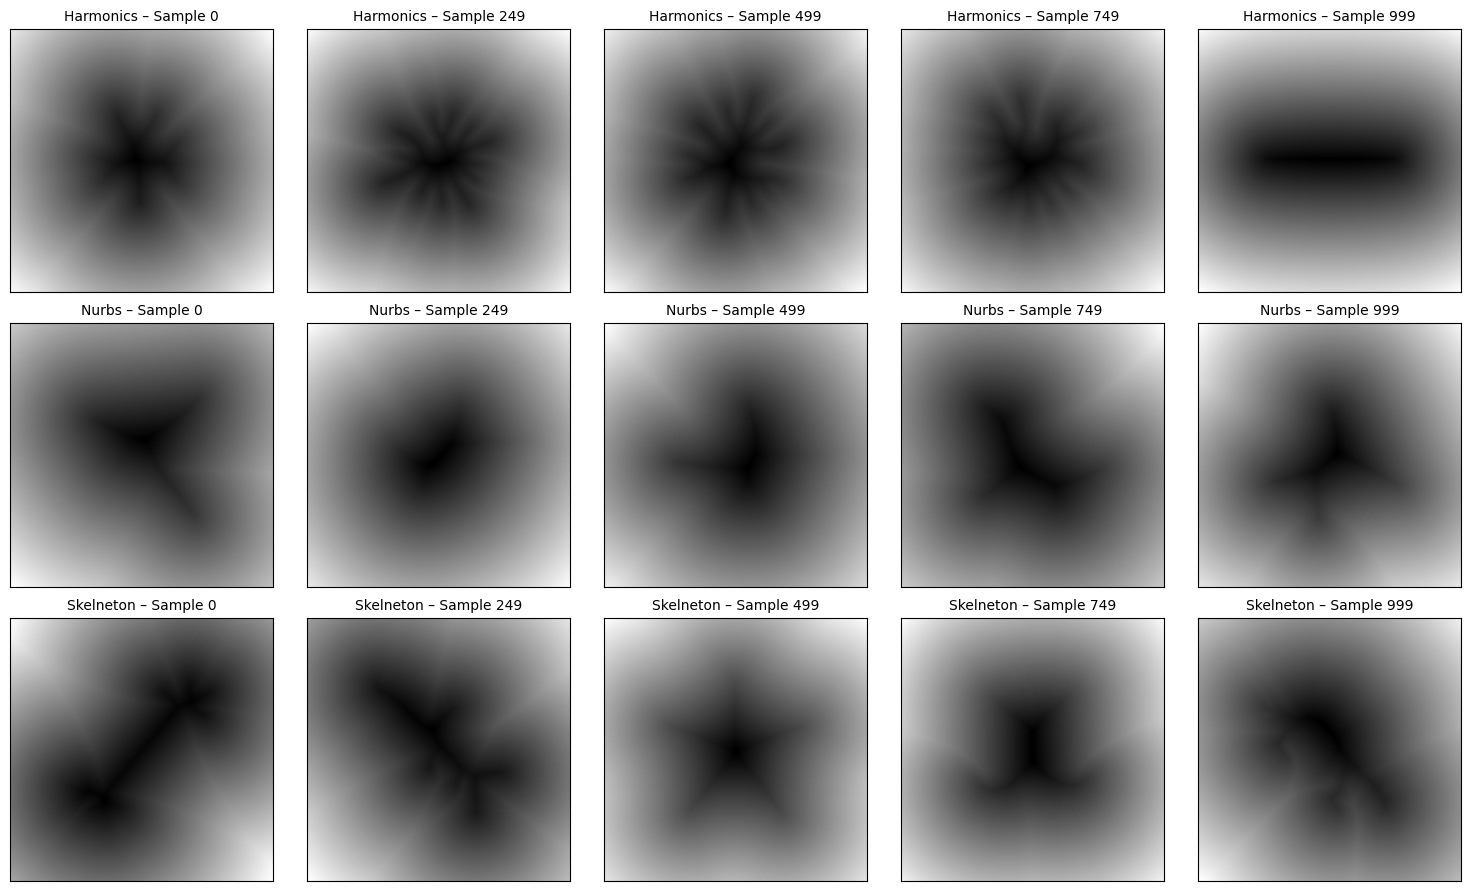

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# Path to dataset folder
path = "/content/drive/MyDrive/ldc_128_naiver_stokes/LDC_NS_2D/128x128"

# Shape groups
variants = ["harmonics", "nurbs", "skelneton"]

# Number of samples to show per group
Ncols = 5   # You can change to 8 or 10 if needed

# Create figure (3 rows × Ncols)
fig, axes = plt.subplots(len(variants), Ncols, figsize=(3*Ncols, 9))

for row, name in enumerate(variants):

    # Load geometry mask (X array: channel-0 = mask)
    X = np.load(f"{path}/{name}_lid_driven_cavity_X.npz")['data']   # shape: [N, 3, 128, 128]

    # Randomly pick sample indices OR you may choose first 5
    sample_ids = np.linspace(0, len(X)-1, Ncols, dtype=int)

    for col, idx in enumerate(sample_ids):

        mask = X[idx, 1]   # Channel 1 = geometry mask

        ax = axes[row, col]
        im = ax.imshow(mask, cmap='gray', origin='lower')

        ax.set_xticks([])
        ax.set_yticks([])

        # Title showing variant + sample ID
        ax.set_title(f"{name.capitalize()} – Sample {idx}", fontsize=10)

plt.tight_layout()
plt.show()


In [18]:
import numpy as np
import os

path = "/content/drive/MyDrive/ldc_128_naiver_stokes/LDC_NS_2D/128x128"
variants = ["harmonics", "nurbs", "skelneton"]

for name in variants:
    X_path = os.path.join(path, f"{name}_lid_driven_cavity_X.npz")
    Y_path = os.path.join(path, f"{name}_lid_driven_cavity_Y.npz")

    X = np.load(X_path)["data"]
    Y = np.load(Y_path)["data"]

    print(f"\n{name.upper()}")
    print(f"  X shape: {X.shape}")
    print(f"  Y shape: {Y.shape}")



HARMONICS
  X shape: (1000, 3, 128, 128)
  Y shape: (1000, 4, 128, 128)

NURBS
  X shape: (1000, 3, 128, 128)
  Y shape: (1000, 4, 128, 128)

SKELNETON
  X shape: (1000, 3, 128, 128)
  Y shape: (1000, 4, 128, 128)


### Inspect Output

harmonics: loaded Y with shape (1000, 4, 128, 128)


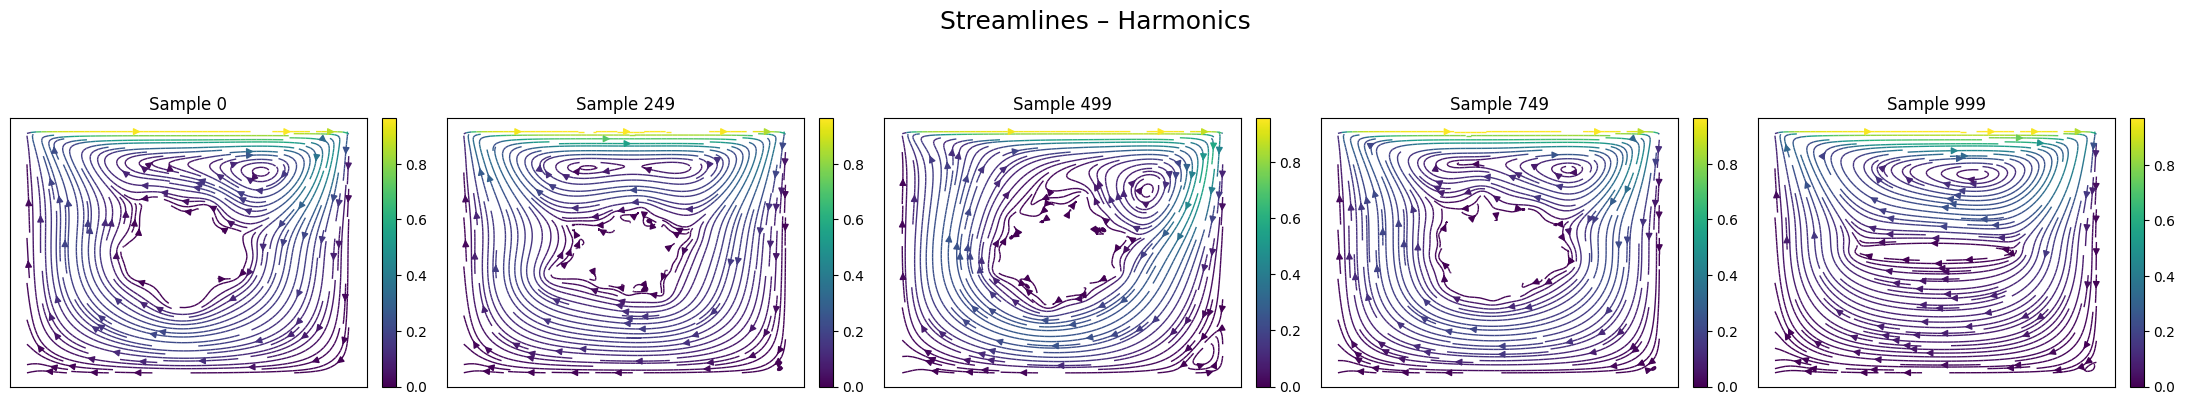

nurbs: loaded Y with shape (1000, 4, 128, 128)


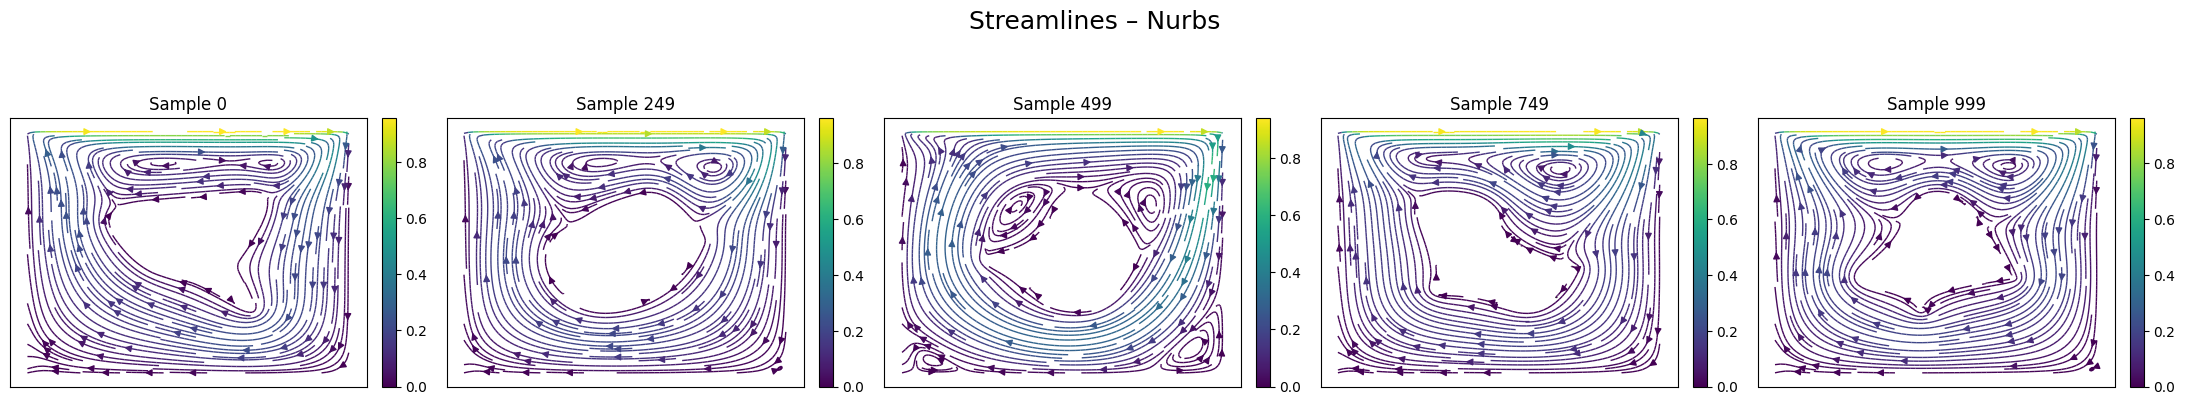

skelneton: loaded Y with shape (1000, 4, 128, 128)


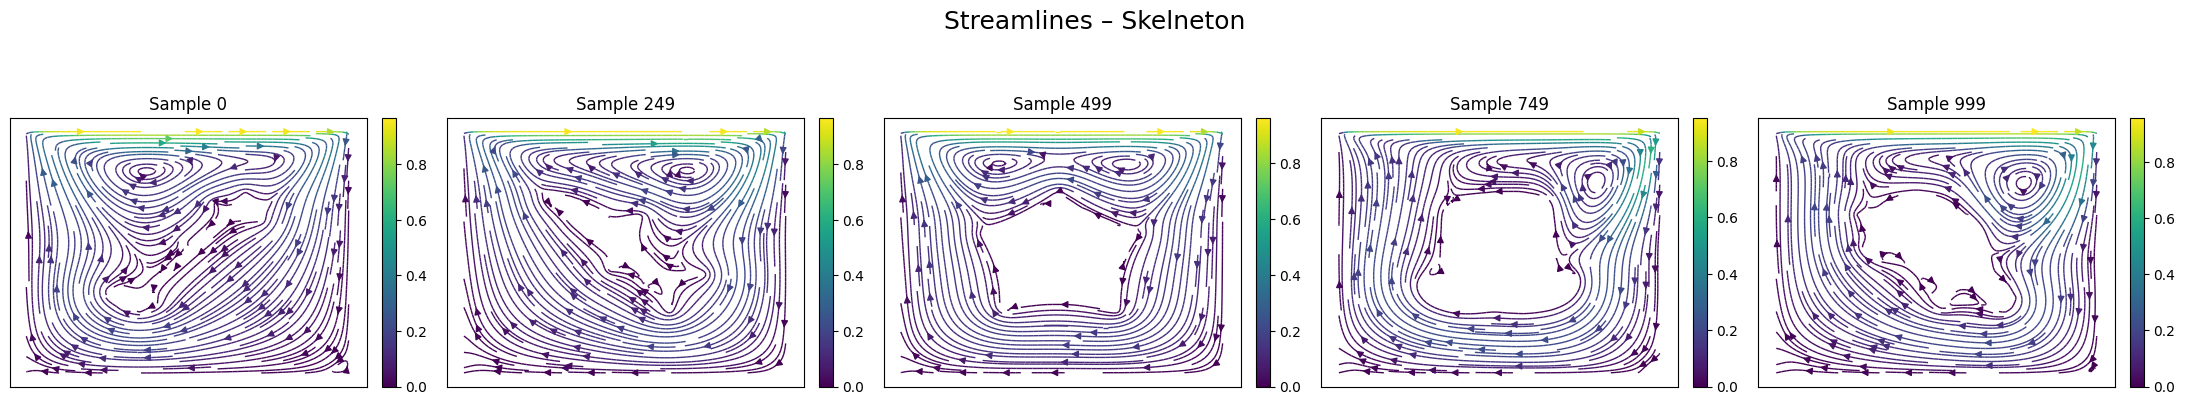

In [21]:
import numpy as np
import matplotlib.pyplot as plt

# Dataset path
path = "/content/drive/MyDrive/ldc_128_naiver_stokes/LDC_NS_2D/128x128"

# Different geometry variants
variants = ["harmonics", "nurbs", "skelneton"]

# Representative sample indices
sample_ids = [0, 249, 499, 749, 999]

# Only velocity channels for streamlines
u_channel = 0
v_channel = 1

# Loop over three variants
for name in variants:

    # Load Y array (shape: [samples, 4, 128, 128])
    Y = np.load(f"{path}/{name}_lid_driven_cavity_Y.npz")["data"]
    print(f"{name}: loaded Y with shape {Y.shape}")

    # Create grid for streamplot
    H, W = Y.shape[2], Y.shape[3]
    x = np.linspace(0, 1, W)
    y = np.linspace(0, 1, H)
    Xg, Yg = np.meshgrid(x, y)

    # Prepare figure: one row = variant, 5 columns = sample IDs
    fig, axes = plt.subplots(1, len(sample_ids), figsize=(22, 4))
    fig.suptitle(f"Streamlines – {name.capitalize()}", fontsize=18)

    # Loop through sample IDs
    for j, idx in enumerate(sample_ids):

        u = Y[idx, u_channel]
        v = Y[idx, v_channel]

        ax = axes[j]
        ax.set_title(f"Sample {idx}")

        # Streamline plot
        strm = ax.streamplot(Xg, Yg, u, v,
                             color=np.sqrt(u**2 + v**2),   # magnitude colormap
                             cmap="viridis",
                             density=2,
                             linewidth=1)

        ax.set_xticks([])
        ax.set_yticks([])

        # Add colorbar to each subplot
        plt.colorbar(strm.lines, ax=ax, fraction=0.046, pad=0.04)

    plt.tight_layout(rect=[0, 0, 1, 0.9])
    plt.show()


# DeepOnet Mode

## Dataset and Datalaoder

In [2]:
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader


In [3]:
class LDCDeepONetDataset(Dataset):
    def __init__(
        self,
        data_dir,
        variants=("harmonics", "nurbs", "skelneton"),
        num_points=1024
    ):
        self.num_points = num_points

        Xs, Ys = [], []

        for name in variants:
            Xs.append(
                np.load(os.path.join(data_dir, f"{name}_lid_driven_cavity_X.npz"))["data"]
            )
            Ys.append(
                np.load(os.path.join(data_dir, f"{name}_lid_driven_cavity_Y.npz"))["data"]
            )

        self.X = np.concatenate(Xs, axis=0)   # (N, 3, 128, 128)
        self.Y = np.concatenate(Ys, axis=0)   # (N, 4, 128, 128)
        self.N = self.X.shape[0]

        # Coordinate grid
        grid = np.linspace(0, 1, 128)
        xx, yy = np.meshgrid(grid, grid, indexing="ij")
        self.coords = np.stack([xx, yy], axis=-1).reshape(-1, 2)

        print("Dataset loaded")
        print("Geometries:", self.N)

    def __len__(self):
        return self.N

    def __getitem__(self, idx):
        # Branch input
        branch = torch.tensor(self.X[idx], dtype=torch.float32)

        # Geometry mask (fluid = 1)
        mask = self.X[idx, 1].reshape(-1) > 0.5

        # Velocity field
        uv = self.Y[idx, :2].reshape(2, -1).T

        # Valid fluid indices
        valid_ids = np.where(mask)[0]

        sample_ids = np.random.choice(
            valid_ids,
            self.num_points,
            replace=False
        )

        trunk = torch.tensor(self.coords[sample_ids], dtype=torch.float32)
        target = torch.tensor(uv[sample_ids], dtype=torch.float32)

        return branch, trunk, target


In [4]:
dataset = LDCDeepONetDataset(
    data_dir="/content/drive/MyDrive/ldc_128_naiver_stokes/LDC_NS_2D/128x128",
    num_points=1024
)

loader = DataLoader(
    dataset,
    batch_size=4,    # number of geometries
    shuffle=True,
    num_workers=2,
    pin_memory=True
)


Dataset loaded
Geometries: 3000


## Model Architecture

In [5]:
class BranchNet(nn.Module):
    def __init__(self, latent_dim=256):
        super().__init__()

        self.net = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(),
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(128, latent_dim)
        )

    def forward(self, x):
        return self.net(x)


In [6]:
class TrunkNet(nn.Module):
    def __init__(self, latent_dim=256):
        super().__init__()

        self.net = nn.Sequential(
            nn.Linear(2, 128), nn.ReLU(),
            nn.Linear(128, 128), nn.ReLU(),
            nn.Linear(128, latent_dim)
        )

    def forward(self, x):
        return self.net(x)


In [7]:
class DeepONet(nn.Module):
    def __init__(self, latent_dim=256, out_dim=2):
        super().__init__()
        self.branch = BranchNet(latent_dim)
        self.trunk = TrunkNet(latent_dim)
        self.fc = nn.Linear(latent_dim, out_dim)

    def forward(self, branch_input, trunk_input):
        # branch_input: (B, 3, 128, 128)
        # trunk_input:  (B, K, 2)

        B, K, _ = trunk_input.shape

        b = self.branch(branch_input)           # (B, D)
        t = self.trunk(trunk_input.view(-1, 2)) # (B*K, D)

        t = t.view(B, K, -1)

        fused = b.unsqueeze(1) * t              # (B, K, D)
        out = self.fc(fused)                    # (B, K, 2)

        return out


## Training Loop

In [8]:
import os
import torch
import torch.nn as nn

# -------- paths --------
checkpoint_dir = "/content/drive/MyDrive/deeponet_checkpoints"
final_model_path = "/content/drive/MyDrive/deeponet_final_model.pt"

os.makedirs(checkpoint_dir, exist_ok=True)


In [9]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = DeepONet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()


In [10]:
start_epoch = 0
checkpoint_path = os.path.join(checkpoint_dir, "latest_checkpoint.pt")

if os.path.exists(checkpoint_path):
    print(f"Loading checkpoint from {checkpoint_path}")
    checkpoint = torch.load(checkpoint_path, map_location=device)

    model.load_state_dict(checkpoint["model_state"])
    optimizer.load_state_dict(checkpoint["optimizer_state"])
    start_epoch = checkpoint["epoch"] + 1

    print(f"Resumed from epoch {start_epoch}")
else:
    print("No checkpoint found. Starting fresh training.")


No checkpoint found. Starting fresh training.


In [11]:
epochs = 50
save_every = 5   # save checkpoint every N epochs

for ep in range(start_epoch, epochs):
    model.train()
    total_loss = 0.0

    for branch, trunk, target in loader:
        branch = branch.to(device)
        trunk = trunk.to(device)
        target = target.to(device)

        optimizer.zero_grad()
        pred = model(branch, trunk)
        loss = criterion(pred, target)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(loader)

    # -------- logging --------
    print(f"Epoch [{ep+1:03d}/{epochs}] | Train Loss: {avg_loss:.6f}")

    # -------- save checkpoint --------
    if (ep + 1) % save_every == 0:
        torch.save(
            {
                "epoch": ep,
                "model_state": model.state_dict(),
                "optimizer_state": optimizer.state_dict(),
                "loss": avg_loss
            },
            checkpoint_path
        )
        print(f"Checkpoint saved at epoch {ep+1}")


Epoch [001/50] | Train Loss: 0.021115
Epoch [002/50] | Train Loss: 0.002330
Epoch [003/50] | Train Loss: 0.001668
Epoch [004/50] | Train Loss: 0.001309
Epoch [005/50] | Train Loss: 0.001070
Checkpoint saved at epoch 5
Epoch [006/50] | Train Loss: 0.000968
Epoch [007/50] | Train Loss: 0.000847
Epoch [008/50] | Train Loss: 0.000756
Epoch [009/50] | Train Loss: 0.000891
Epoch [010/50] | Train Loss: 0.000917
Checkpoint saved at epoch 10
Epoch [011/50] | Train Loss: 0.000845
Epoch [012/50] | Train Loss: 0.000696
Epoch [013/50] | Train Loss: 0.000539
Epoch [014/50] | Train Loss: 0.000533
Epoch [015/50] | Train Loss: 0.000550
Checkpoint saved at epoch 15
Epoch [016/50] | Train Loss: 0.000431
Epoch [017/50] | Train Loss: 0.000437
Epoch [018/50] | Train Loss: 0.000419
Epoch [019/50] | Train Loss: 0.000329
Epoch [020/50] | Train Loss: 0.000345
Checkpoint saved at epoch 20
Epoch [021/50] | Train Loss: 0.000370
Epoch [022/50] | Train Loss: 0.000332
Epoch [023/50] | Train Loss: 0.000295
Epoch [024/

In [12]:
torch.save(model.state_dict(), final_model_path)
print(f"Final model saved to {final_model_path}")


Final model saved to /content/drive/MyDrive/deeponet_final_model.pt


## Inference

In [13]:
import torch
import numpy as np
import matplotlib.pyplot as plt


In [14]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = DeepONet().to(device)
model.load_state_dict(
    torch.load("/content/drive/MyDrive/deeponet_final_model.pt", map_location=device)
)
model.eval()

print("Model loaded")


✅ Model loaded


In [15]:
grid = np.linspace(0, 1, 128)
xx, yy = np.meshgrid(grid, grid, indexing="ij")
coords = np.stack([xx, yy], axis=-1)          # (128, 128, 2)
coords = coords.reshape(-1, 2)                # (16384, 2)

coords_t = torch.tensor(coords, dtype=torch.float32).to(device)


In [16]:
data_dir = "/content/drive/MyDrive/ldc_128_naiver_stokes/LDC_NS_2D/128x128"
name = "harmonics"   # or "nurbs", "skeleton"
sample_id = 0        # choose any index

X = np.load(f"{data_dir}/{name}_lid_driven_cavity_X.npz")["data"]
Y = np.load(f"{data_dir}/{name}_lid_driven_cavity_Y.npz")["data"]

branch = torch.tensor(X[sample_id], dtype=torch.float32).unsqueeze(0).to(device)
gt_uv = Y[sample_id, :2]   # (2, 128, 128)


In [17]:
def infer_full_field(model, branch, coords, chunk_size=2048):
    preds = []

    with torch.no_grad():
        for i in range(0, coords.shape[0], chunk_size):
            coord_chunk = coords[i:i+chunk_size].unsqueeze(0)  # (1, K, 2)
            pred = model(branch, coord_chunk)                  # (1, K, 2)
            preds.append(pred.squeeze(0).cpu())

    preds = torch.cat(preds, dim=0)   # (16384, 2)
    return preds


In [18]:
pred_uv = infer_full_field(model, branch, coords_t)
pred_uv = pred_uv.T.reshape(2, 128, 128).numpy()


In [19]:
u_gt, v_gt = gt_uv
u_pr, v_pr = pred_uv

mag_gt = np.sqrt(u_gt**2 + v_gt**2)
mag_pr = np.sqrt(u_pr**2 + v_pr**2)


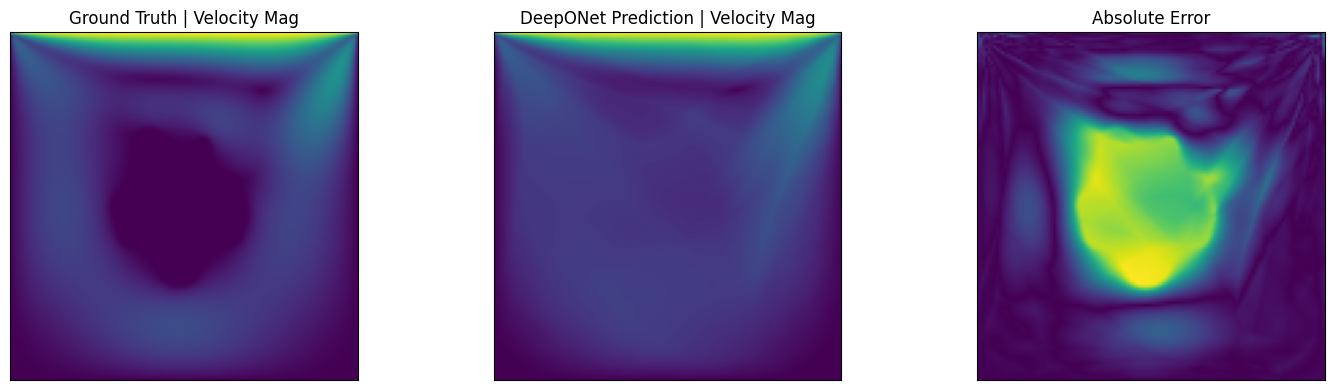

In [20]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].imshow(mag_gt, origin="lower")
axes[0].set_title("Ground Truth | Velocity Mag")

axes[1].imshow(mag_pr, origin="lower")
axes[1].set_title("DeepONet Prediction | Velocity Mag")

axes[2].imshow(np.abs(mag_gt - mag_pr), origin="lower")
axes[2].set_title("Absolute Error")

for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.show()


In [23]:
x = np.linspace(0, 1, 128)
y = np.linspace(0, 1, 128)

X, Y = np.meshgrid(x, y, indexing="xy")  # <-- FIX


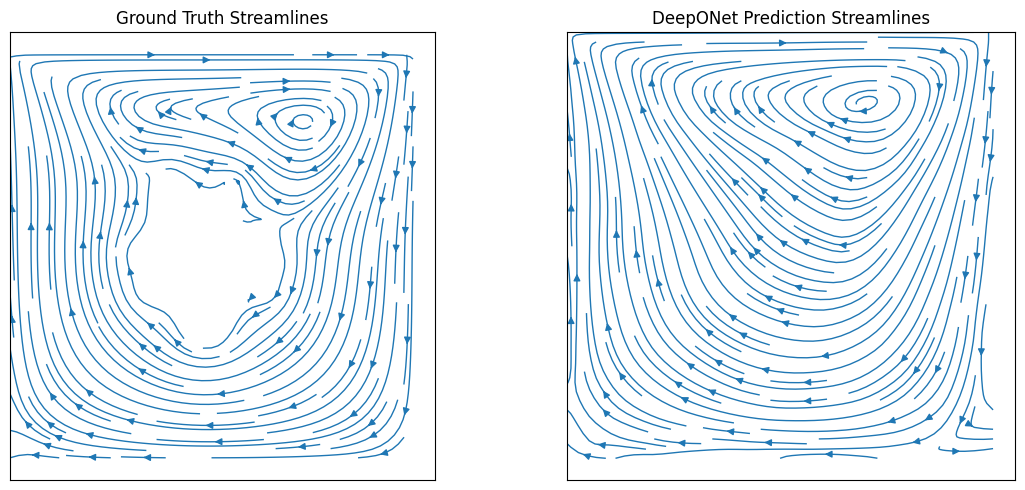

In [24]:
# Grid
x = np.linspace(0, 1, 128)
y = np.linspace(0, 1, 128)
X, Y = np.meshgrid(x, y, indexing="xy")

# Streamlines
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].streamplot(
    X, Y, u_gt, v_gt,
    density=1.5,
    linewidth=1
)
axes[0].set_title("Ground Truth Streamlines")
axes[0].set_aspect("equal")

axes[1].streamplot(
    X, Y, u_pr, v_pr,
    density=1.5,
    linewidth=1
)
axes[1].set_title("DeepONet Prediction Streamlines")
axes[1].set_aspect("equal")

for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.show()
